## Regression on Statcast


In [1]:
from __future__ import print_function, division

# all of the imports
import pandas as pd
import numpy as np
import scipy.stats as stats
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')



/Users/Tom/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/Tom/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import data frames

ball_data gives averages in a given year
event_data contains each explicit batted ball event

In [2]:
# Data from Fangraphs for qualified batters 2010 - 2017
fangraphs_stats = pd.read_pickle('fangraphs.pkl')

# Data scraped from Baseball Savant
savant_stats = pd.read_pickle('savant.pkl')

# Statcast data of all batted balls in play + HR for 2015 - 2017 grouped by batter and year
ball_data = pd.read_pickle('angle.pkl')

# Statcast data of each batted balls in play + HR for 2015 - 2017
event_data = pd.read_pickle('event.pkl')

In [3]:
# Make sure all numeric data is properly typed

savant_stats = savant_stats.apply(pd.to_numeric,errors = 'ignore')
fangraphs_stats = fangraphs_stats.apply(pd.to_numeric,errors = 'ignore')
ball_data = ball_data.apply(pd.to_numeric,errors = 'ignore')

In [4]:
# Merge Statcast stats with fangraphs data 
stats_ = pd.merge(fangraphs_stats,ball_data,on = ['Name','Year']).copy()


In [5]:
stats_[['Name','Year','change_speed','change_angle','change_HR']].sort_values('change_speed')

,Name,Year,change_speed,change_angle,change_HR
153,Joey Gallo,2017,-14.241489,-4.884468,-0.776596
227,Trevor Story,2017,-10.838493,4.422478,-0.196955
155,Keon Broxton,2017,-7.453488,-1.249802,-0.014609
282,Aledmys Diaz,2017,-6.584019,-1.169200,-0.068982
267,Carlos Gonzalez,2017,-6.401342,-5.849872,-0.042959
312,Chris Carter,2016,-5.772581,2.190640,-0.068664
179,Yasiel Puig,2017,-5.760881,-0.177177,0.008321
411,Zack Cozart,2016,-5.647678,-3.851207,-0.159836
244,Albert Pujols,2017,-5.382842,0.891640,-0.025090
278,Jason Kipnis,2017,-5.150469,0.564851,-0.037580


### Drop outlier

In [6]:
stats_.loc[stats_.change_HR < -0.1][['Name','Year','change_HR','change_speed','change_angle']]

,Name,Year,change_HR,change_speed,change_angle
153,Joey Gallo,2017,-0.776596,-14.241489,-4.884468
161,Trey Mancini,2017,-0.213043,-3.989814,-9.401350
206,Yasmani Grandal,2017,-0.106700,-3.564952,-5.526571
227,Trevor Story,2017,-0.196955,-10.838493,4.422478
237,Brian Dozier,2017,-0.102444,-2.828304,0.523219
411,Zack Cozart,2016,-0.159836,-5.647678,-3.851207


In [7]:
# drop NaN
stats_ = stats_.drop(153,).dropna()

In [8]:
stats_.shape

(303, 53)

# The idea

Recent spike in leaguewide HR totals have been ascribed to adjustments based on Statcast data. Namely, players are increasing their batted ball launch angle which is leading to better outcomes (Specifically, more homeruns)

## The plan

Download batted ball data for all years for which Statcast data is available (2015 - 2017). 
Look for a connection in change in launch angle and launch speed with increased BABIP, SLG and homerun rates.

At first I looked at years seperately thinking under the assumption relationships should not change too much from year to year. This helped me identify annomolous data within each year. Also, 

# Question 1

Are adjustments players are making leading to better outcomes?

### Approach

See if change in launch angle, which is presumably due to change in player's swing, leads to better outcomes. 

Dependent variables

change_SLG = the change in the number of bases per batted ball

change_hit = the change in the number of hits per batted ball

change_HR = the change in the number of homeruns per batted ball

In [9]:
deltas = ['change_angle','change_speed','change_SLG','change_hit','change_HR']

In [10]:
stats_17 = stats_[stats_['Year'] == 2017][deltas]

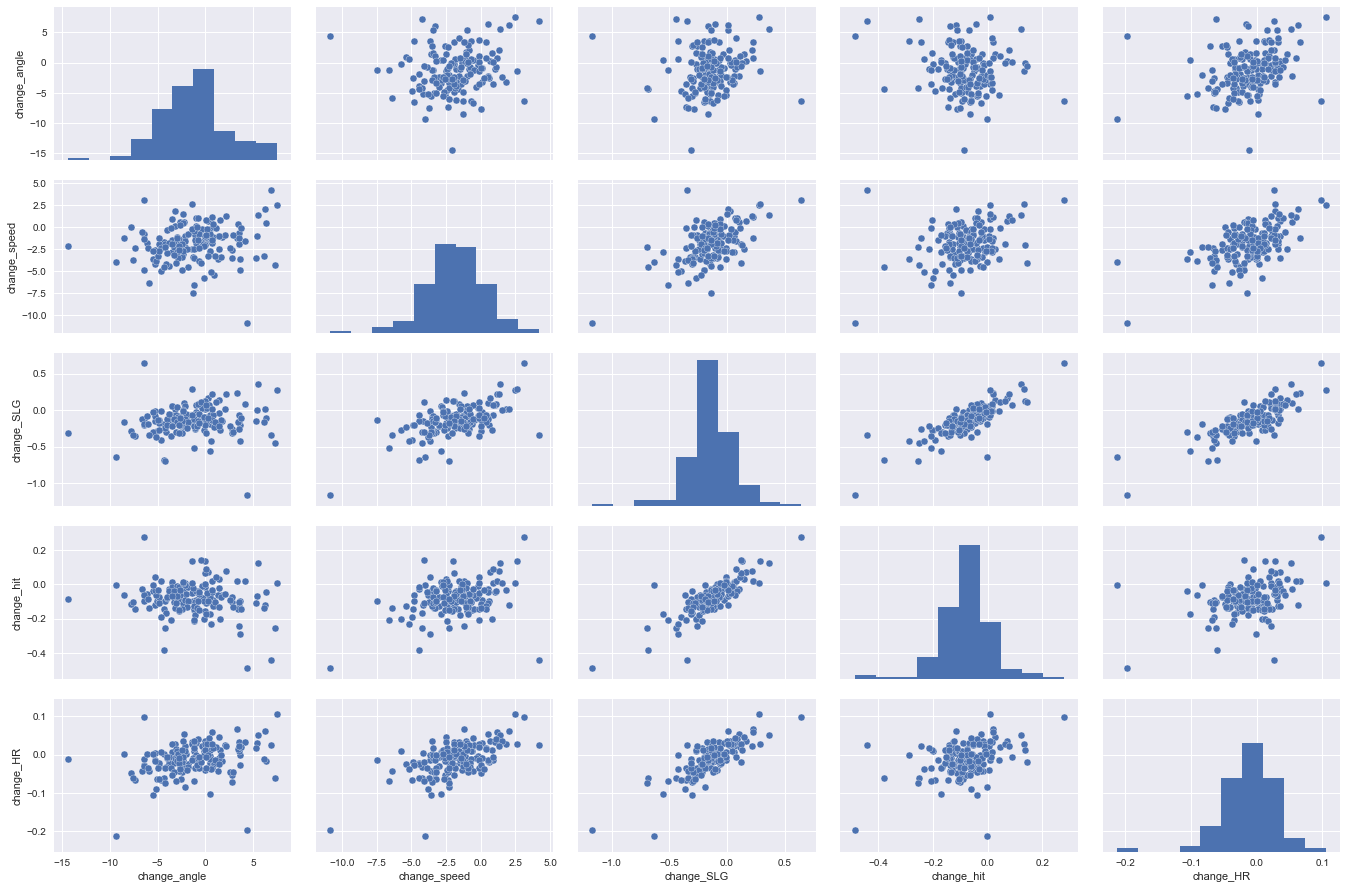

In [11]:
plt.figure(figsize=(12,10))
sns.pairplot(stats_17, size = 2.5, aspect=1.5);

In [12]:
stats_16 = stats_[stats_['Year'] == 2016][deltas]

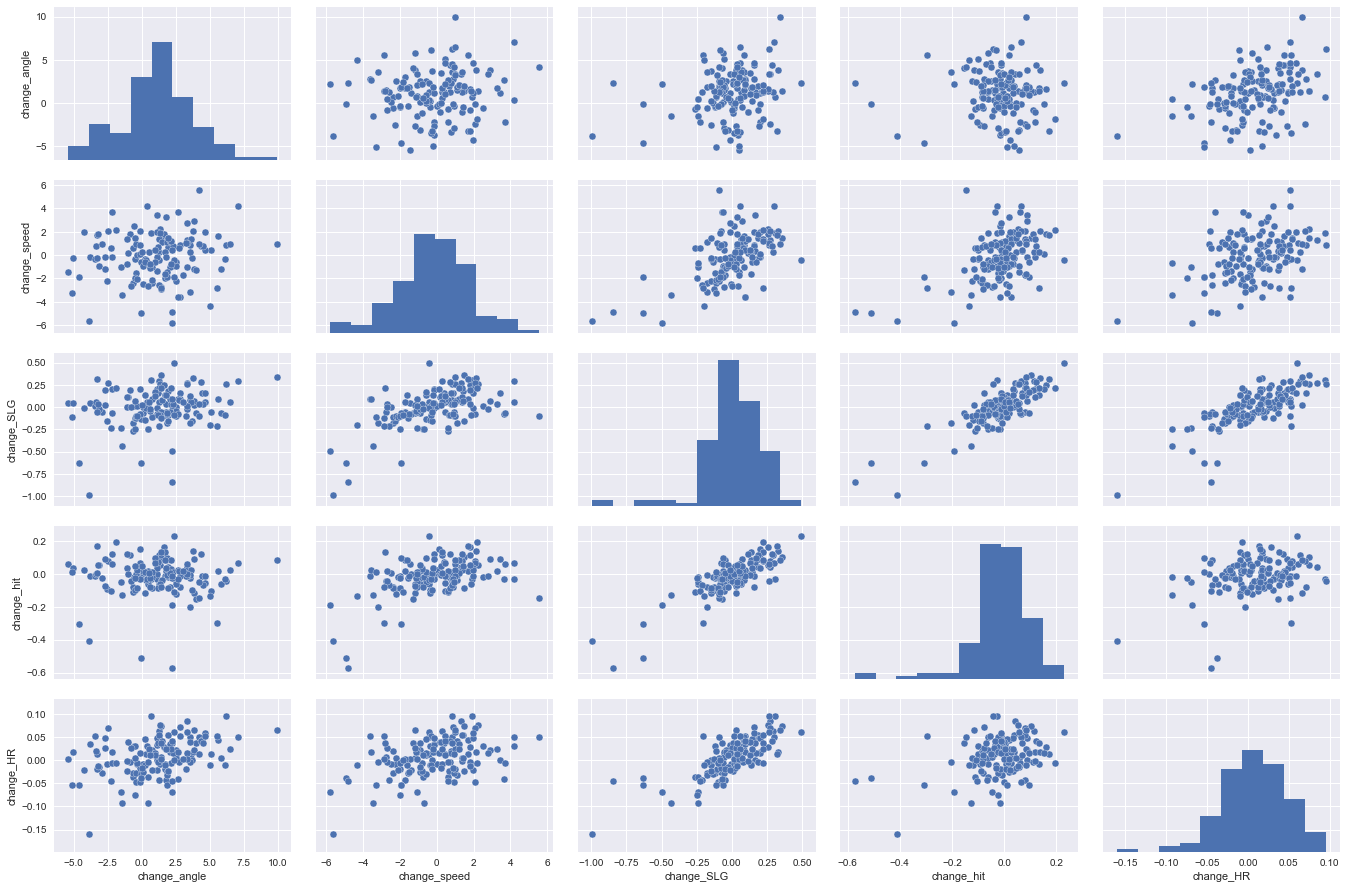

In [13]:
plt.figure(figsize=(12,10));
sns.pairplot(stats_16, size = 2.5, aspect=1.5);

### Putting data back together

In [14]:
stats_1617 = stats_[deltas]

In [15]:
stats_1617.shape

(303, 5)

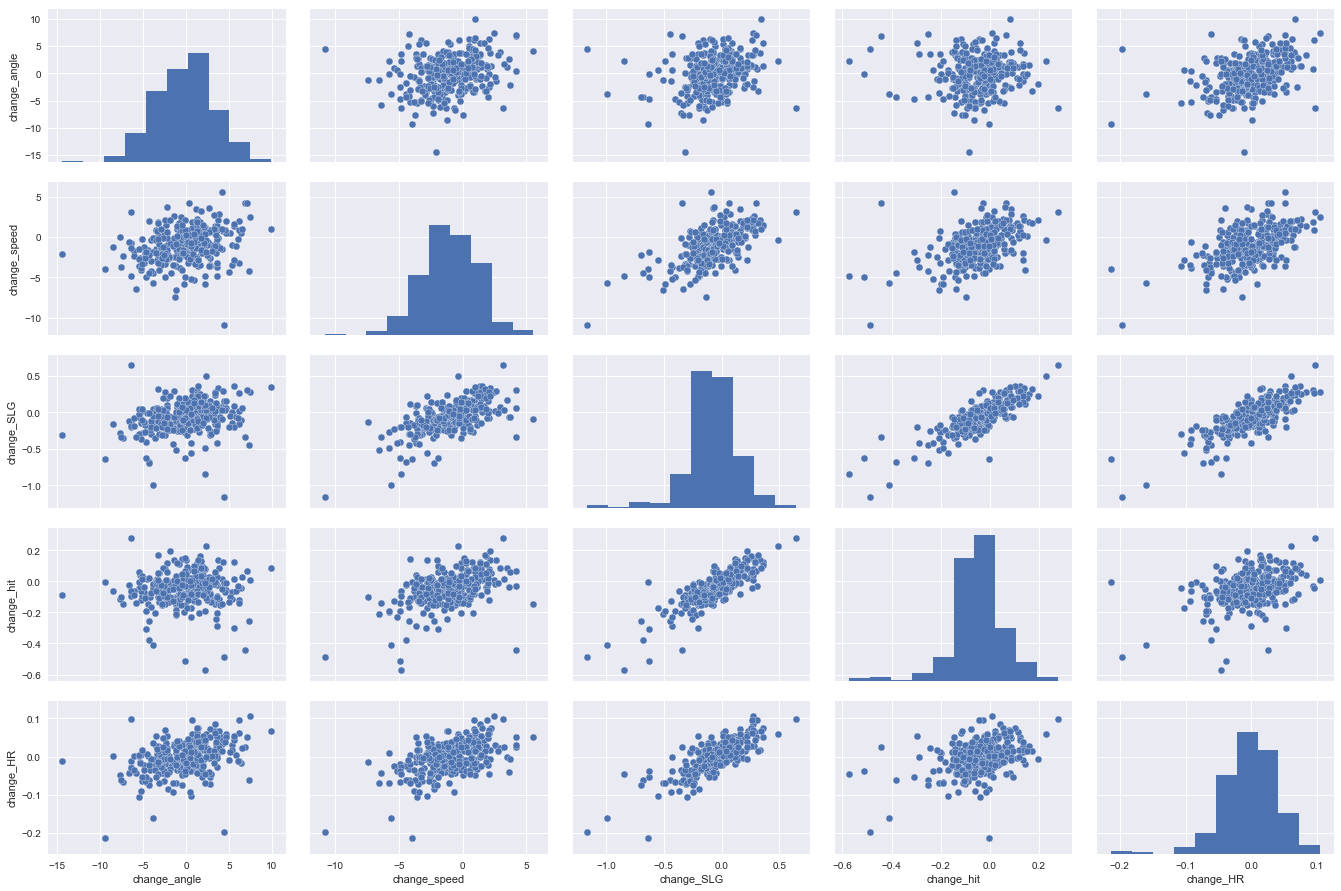

In [16]:
plt.figure(figsize=(12,10))
sns.pairplot(stats_1617, size = 2.5, aspect=1.5)

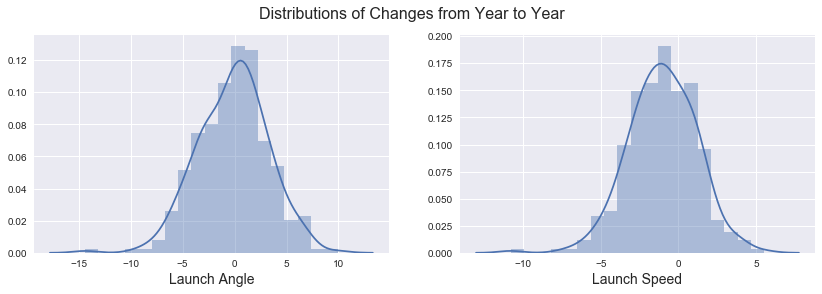

In [17]:
f = plt.figure(figsize=(14,4))
f.suptitle('Distributions of Changes from Year to Year', fontsize=16)

ax1 = plt.subplot(121)
sns.distplot(stats_1617['change_angle'])
ax1.set_xlabel('Launch Angle',fontsize = 14)

ax2 = plt.subplot(122)
sns.distplot(stats_1617['change_speed'])
ax2.set_xlabel('Launch Speed',fontsize = 14)



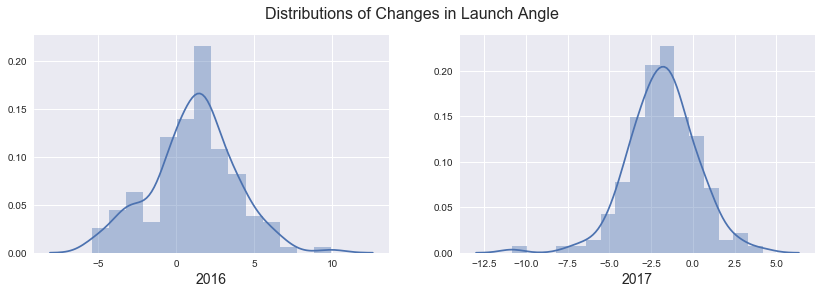

In [18]:
f = plt.figure(figsize=(14,4))
f.suptitle('Distributions of Changes in Launch Angle', fontsize=16)

ax1 = plt.subplot(121)
sns.distplot(stats_16['change_angle'])
ax1.set_xlabel('2016',fontsize = 14)

ax2 = plt.subplot(122)
sns.distplot(stats_17['change_speed'])
ax2.set_xlabel('2017',fontsize = 14)



In [19]:
stats_1617.corr()

,change_angle,change_speed,change_SLG,change_hit,change_HR
change_angle,1.000000,0.266344,0.267832,0.023475,0.386045
change_speed,0.266344,1.000000,0.623173,0.483328,0.542617
change_SLG,0.267832,0.623173,1.000000,0.840900,0.793029
change_hit,0.023475,0.483328,0.840900,1.000000,0.392116
change_HR,0.386045,0.542617,0.793029,0.392116,1.000000


In [20]:
stats_v2 = stats_1617.copy()

In [21]:
stats_v2['change_SLG'] = stats_v2['change_SLG'].apply(lambda x: 1000*x)
stats_v2['change_hit'] = stats_v2['change_hit'].apply(lambda x: 1000*x)
stats_v2['change_HR'] = stats_v2['change_HR'].apply(lambda x: 1000*x)

stats_v2.corr()

,change_angle,change_speed,change_SLG,change_hit,change_HR
change_angle,1.000000,0.266344,0.267832,0.023475,0.386045
change_speed,0.266344,1.000000,0.623173,0.483328,0.542617
change_SLG,0.267832,0.623173,1.000000,0.840900,0.793029
change_hit,0.023475,0.483328,0.840900,1.000000,0.392116
change_HR,0.386045,0.542617,0.793029,0.392116,1.000000


In [22]:
stats_v2.rename(columns = {'change_HR':'change_HR_p_BatB',
                           'change_SLG':'change_Bases_p_BatB',
                           'change_hit':'change_Hits_p_BatB'}, inplace = True)

In [23]:
stats_v2.corr()

,change_angle,change_speed,change_Bases_p_BatB,change_Hits_p_BatB,change_HR_p_BatB
change_angle,1.000000,0.266344,0.267832,0.023475,0.386045
change_speed,0.266344,1.000000,0.623173,0.483328,0.542617
change_Bases_p_BatB,0.267832,0.623173,1.000000,0.840900,0.793029
change_Hits_p_BatB,0.023475,0.483328,0.840900,1.000000,0.392116
change_HR_p_BatB,0.386045,0.542617,0.793029,0.392116,1.000000


### Modeling

In [24]:
stats_1617.describe()

,change_angle,change_speed,change_SLG,change_hit,change_HR
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,-0.150193,-1.032281,-0.072221,-0.049366,-0.002423
std,3.363721,2.193306,0.215009,0.107249,0.041959
min,-14.382818,-10.838493,-1.167675,-0.572596,-0.213043
25%,-2.508251,-2.434488,-0.179781,-0.101081,-0.026324
50%,0.056484,-1.041396,-0.075516,-0.044389,-0.001485
75%,1.990852,0.541824,0.058301,0.009657,0.025126
max,9.918993,5.551942,0.643332,0.277003,0.104991


In [25]:
stats_1617.sort_values('change_HR')[:5]

,change_angle,change_speed,change_SLG,change_hit,change_HR
161,-9.401350,-3.989814,-0.636646,-0.003106,-0.213043
227,4.422478,-10.838493,-1.167675,-0.486239,-0.196955
411,-3.851207,-5.647678,-0.991803,-0.409836,-0.159836
206,-5.526571,-3.564952,-0.302119,-0.040235,-0.106700
237,0.523219,-2.828304,-0.553985,-0.171014,-0.102444


Use linear regression to model the relationship between change in launch andgle, change in batted ball launch speed and an outcome metric. We look at the change in hits per plate appearance, change in bases per plate appearance, and change in homeruns per plate appearance. We will add polynomial features since the relationship between change in launch angle and result metric would would not be monotonic. (Increasing average launch angle by too much would lead to more fly ball outs and fewer hits and homeruns)

In [26]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV


{1: 0.31152483303584466, 2: 0.234279260566714, 3: -0.018257924482615984, 4: -0.097733456206386959, 5: -4.4277188693992811, 6: -145.30068817260215}


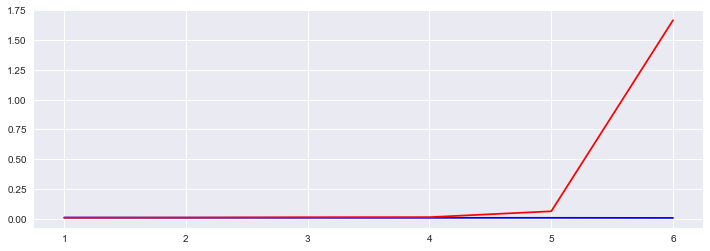

In [27]:
# Model change in launch speed and angle vs change in hits per batted ball

degrees = range(1,7)
scores = {}

X = stats_1617[['change_speed','change_angle']]
y_h = stats_1617['change_hit']

MSE_train_h = []
MSE_test_h = []

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X, y_h, test_size=0.3)

for degree in degrees:
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    est.fit(X_train_h,y_train_h)
    scores[degree] = est.score(X_test_h,y_test_h)
    MSE_train_h.append(metrics.mean_squared_error(y_train_h,est.predict(X_train_h)))
    MSE_test_h.append(metrics.mean_squared_error(y_test_h,est.predict(X_test_h)))

plt.figure(figsize=(12,4))

plt.plot(degrees,MSE_train_h, color = 'b')
plt.plot(degrees,MSE_test_h, color = 'r')    

print(scores)


[0.31708788209327343, 0.27851856701434519, 0.28899821952180971, 0.16510912632101382, -0.56943260897458159, -0.034129077337685443]


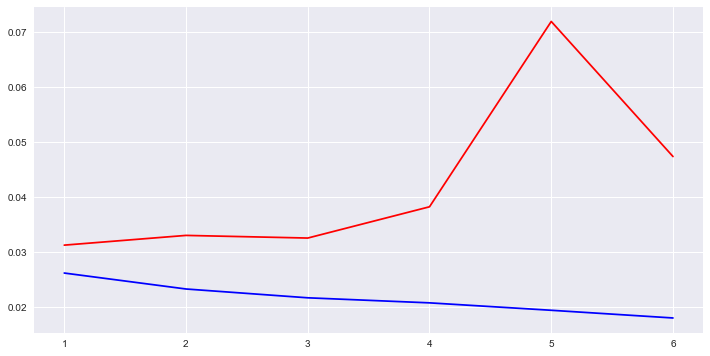

In [28]:
# Model change in launch speed and angle vs change in bases per batted ball

degrees = range(1,7)
scores = []

X = stats_1617[['change_speed','change_angle']]
y_s = stats_1617['change_SLG']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.3)

MSE_train_s = []
MSE_test_s = []

for degree in degrees:
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    est.fit(X_train_s,y_train_s)
    scores.append(est.score(X_test_s,y_test_s))
    est.predict(X_test_s)
    MSE_train_s.append(metrics.mean_squared_error(y_train_s,est.predict(X_train_s)))
    MSE_test_s.append(metrics.mean_squared_error(y_test_s,est.predict(X_test_s)))

plt.figure(figsize=(12,6))
    
plt.plot(degrees,MSE_train_s, color = 'b')
plt.plot(degrees,MSE_test_s, color = 'r')

print(scores)


[0.40525418432195393, 0.38212637919566017, 0.28686456937219584, 0.10501238023271631, -60.807225259432208, -247.00367926145253]


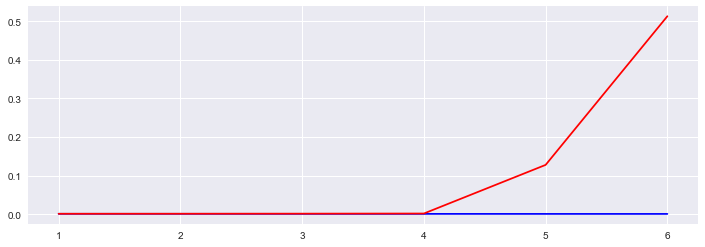

In [29]:
# Model change in launch speed and angle vs change in HR per batted ball

degrees = range(1,7)
scores = []

X = stats_1617[['change_speed','change_angle']]
y_hr = stats_1617['change_HR']

MSE_train_hr = []
MSE_test_hr = []

X_train_hr, X_test_hr, y_train_hr, y_test_hr = train_test_split(X, y_hr, test_size=0.3)

for degree in degrees:
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    est.fit(X_train_hr,y_train_hr)
    
    scores.append(est.score(X_test_hr,y_test_hr))
    MSE_train_hr.append(metrics.mean_squared_error(y_train_hr,est.predict(X_train_hr)))
    MSE_test_hr.append(metrics.mean_squared_error(y_test_hr,est.predict(X_test_hr)))


plt.figure(figsize=(12,4))

plt.plot(degrees,MSE_train_hr, color = 'b')
plt.plot(degrees,MSE_test_hr, color = 'r')

print(scores)


# Regularization

Clearly, adding ploynomial features beyond 3 degrees is hurting the model more than it is helping. Introduce cross-validation to prevent over-fitting.

### Ridge Cross-Validation

In [30]:
# Model change in launch speed and angle vs change in hits per batted ball
# With Ridge cross validation

degrees = range(1,4)
scores = {}
ridge_models = {}

X = stats_1617[['change_speed','change_angle']]
y_h = stats_1617['change_hit']

alphas = [10 ** n for n in range(-4,9)]


for degree in degrees:
    est = make_pipeline(PolynomialFeatures(degree), RidgeCV(alphas,cv = 10))

    est.fit(X_train_h,y_train_h)
    scores[degree] = est.score(X_test_h,y_test_h)
    ridge_models[degree] = est


print(scores)


{1: 0.31003667431863402, 2: 0.2176943244676407, 3: -0.018257906523620138}


In [31]:
# Examine Coefficients

for x in ridge_models:
    print(ridge_models[x].named_steps['ridgecv'].coef_)

[ 0.          0.02239045 -0.00357461]
[ 0.          0.0131037  -0.00207768 -0.00249154  0.00068451 -0.00105347]
[ 0.          0.02741419  0.00501172 -0.00295982 -0.00099281 -0.00156628
 -0.00037244 -0.00083965 -0.00036309 -0.0001283 ]


In [32]:
# Model change in launch speed and angle vs change in HR per batted ball
# With Ridge cross validation

degrees = range(1,4)
scores = {}
ridge_models = {}

X = stats_1617[['change_speed','change_angle']]
y_hr = stats_1617['change_HR']

alphas = [10 ** n for n in range(-4,9)]


for degree in degrees:
    est = make_pipeline(PolynomialFeatures(degree), RidgeCV(alphas,cv = 10))

    est.fit(X_train_hr,y_train_hr)
    scores[degree] = est.score(X_test_hr,y_test_hr)
    ridge_models[degree] = est


print(scores)


{1: 0.3902319978541996, 2: 0.39266513550929905, 3: 0.36326978158528878}


In [33]:
# Examine alphas used in CV model
for x in ridge_models:
    print(ridge_models[x].named_steps['ridgecv'].alpha_)

100
100
100


In [34]:
# Examine Coefficients

for x in ridge_models:
    print(ridge_models[x].named_steps['ridgecv'].coef_)

[ 0.          0.00714092  0.00314479]
[  0.00000000e+00   6.85818039e-03   2.61857218e-03  -2.59449327e-04
  -4.94554892e-04   3.46754889e-05]
[  0.00000000e+00   4.86452232e-03   3.05427751e-03  -5.85322765e-04
  -7.38523912e-04   3.20062002e-04  -1.05089003e-04  -1.20342352e-04
   3.21144675e-04  -3.69928663e-05]


### Residuals

In [35]:
import scipy.stats as stats

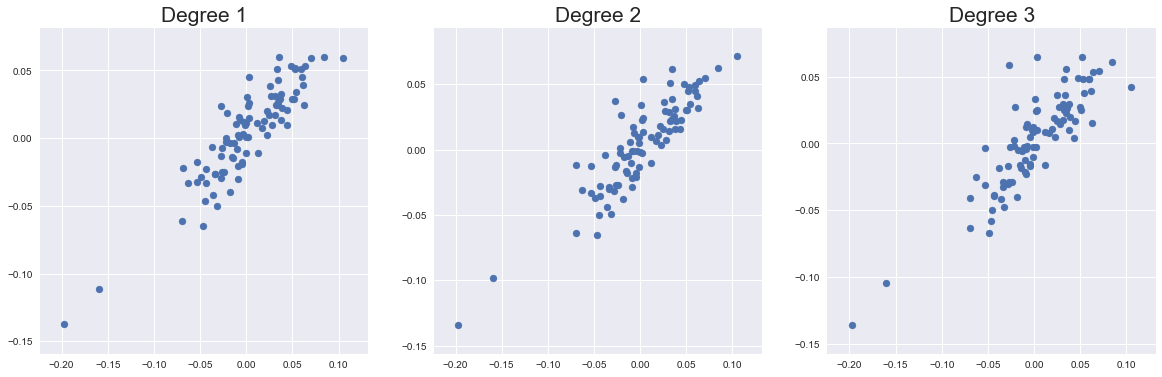

In [36]:
fig,ax = plt.subplots(1,3,figsize=(20,6))
x = np.arange(-15,10,0.2)
f.suptitle('Residual Plots')

for degree in degrees:

    y_pred = ridge_models[degree].predict(X_test_hr)
    residuals = y_test_hr - y_pred

    ax[degree - 1].scatter(y_test_hr,residuals)
    ax[degree - 1].set_title('Degree {}'.format(degree), fontsize=21)

plt.show()



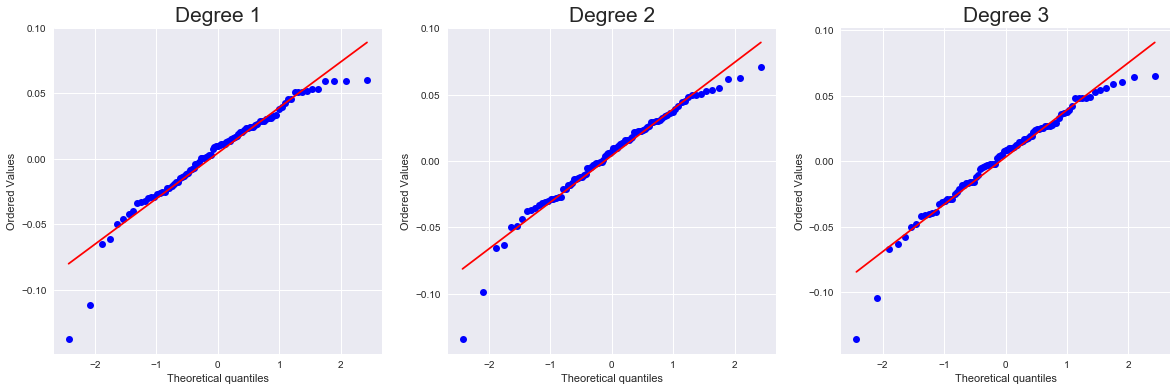

In [37]:
fig,ax = plt.subplots(1,3,figsize=(20,6))
x = np.arange(-15,10,0.2)


for degree in degrees:

    y_pred = ridge_models[degree].predict(X_test_hr)
    residuals = y_test_hr - y_pred

    stats.probplot(residuals, dist="norm", plot=ax[degree - 1])
    ax[degree - 1].set_title('Degree {}'.format(degree),fontsize=21)


plt.show()



## Model Visualization

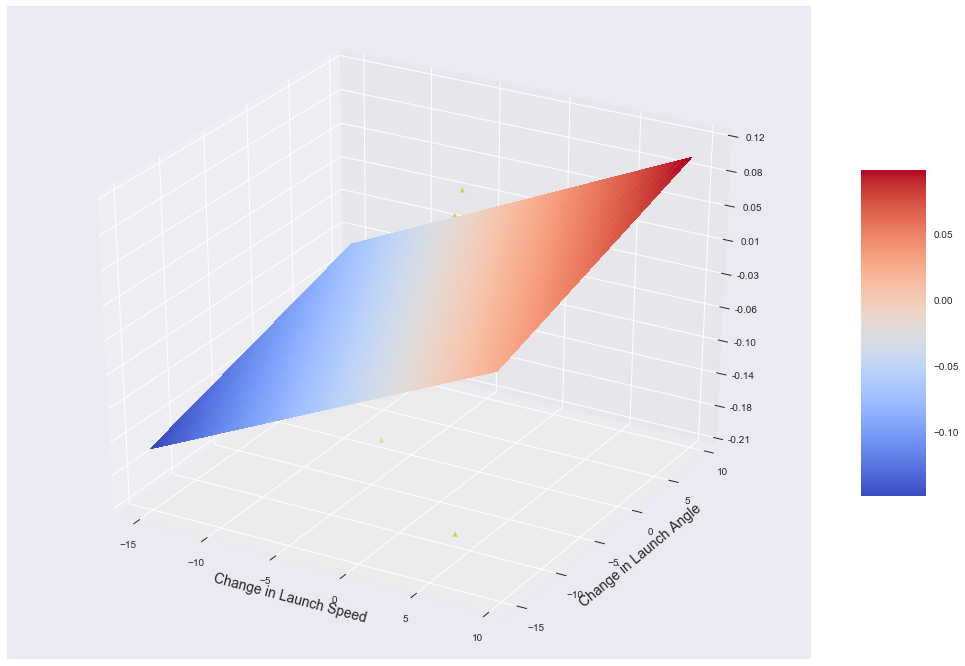

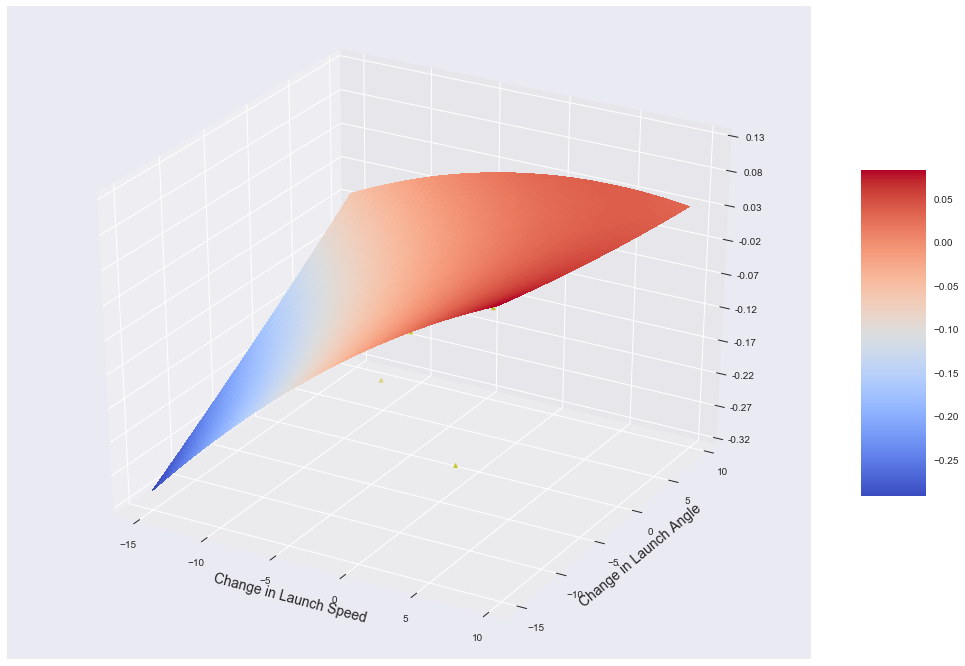

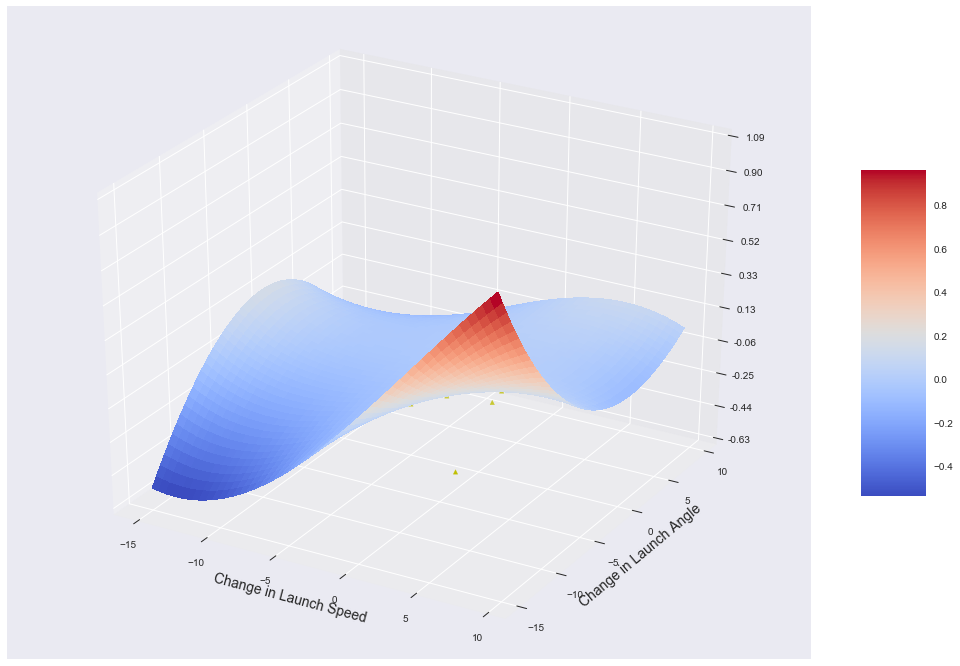

In [38]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

x1 = np.arange(-15,10,0.5)

X,Y = np.meshgrid(x1, x1)


for degree in degrees:
    Z = ridge_models[degree].predict(np.c_[X.ravel(),Y.ravel()])

    fig = plt.figure(figsize=(18,12))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z.reshape(50,50), rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.set_xlabel('Change in Launch Speed', fontsize= 14)
    ax.set_ylabel('Change in Launch Angle', fontsize= 14)
    ax.scatter(X_test_hr['change_angle'],X_test_hr['change_speed'],y_test_hr, c='y',marker='^')

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

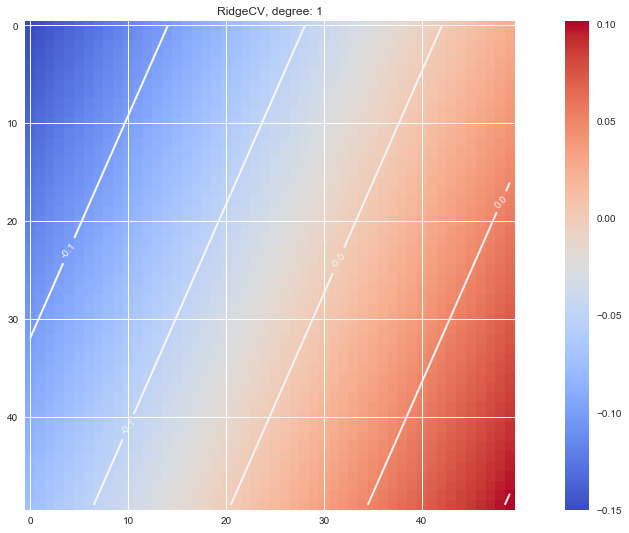

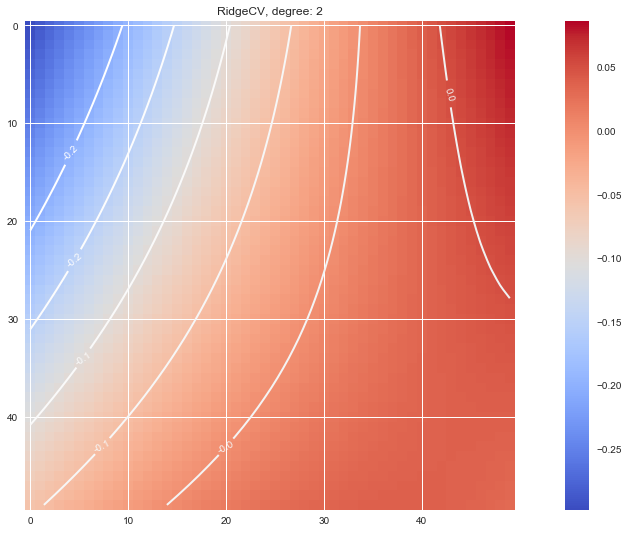

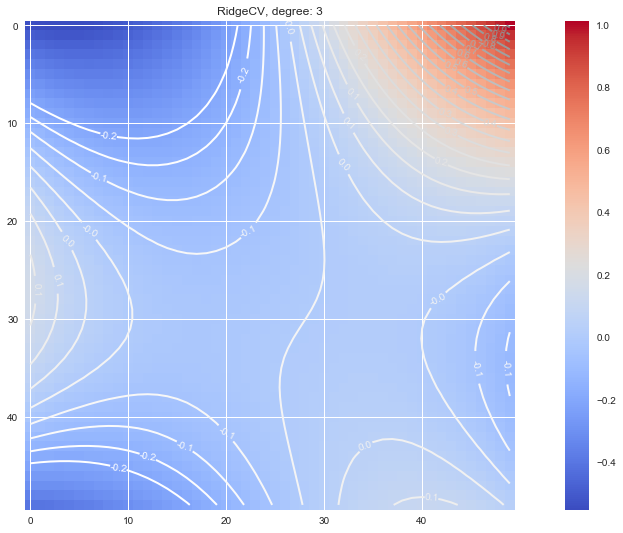

In [39]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

x1 = np.arange(-15,10,0.5)

X,Y = np.meshgrid(x1, x1)

for degree in [1,2,3]:

    Z = ridge_models[degree].predict(np.c_[X.ravel(),Y.ravel()])

    fig = plt.figure(figsize=(18,9))

    im = imshow(Z.reshape(50,50),cmap=cm.coolwarm) # drawing the function
    # adding the Contour lines with labels
    cset = contour(Z.reshape(50,50),np.arange(-.2,2,.05),linewidths=2)
    clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    colorbar(im) # adding the colobar on the right
    # latex fashion title

    title('RidgeCV, degree: {}'.format(degree))
    plt.show()